In [18]:
import os
import json
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

np.random.seed(seed=8675309)

In [19]:
def read_in_data(rand_split, sample=None):
    data = restack_data(np.loadtxt("./image-train.txt", max_rows=sample).astype(int))
    data = data/255
    labels = np.loadtxt("./label-train.txt", max_rows=sample).astype(int).reshape(-1,1)

    # randomly split the data
    n = data.shape[0]
    rand_sort = np.random.shuffle(list(range(n)))
    
    splits = []
    stop_holder = 0
    for i, v in enumerate(rand_split):
        if i == 0:
            start = 0
        else:
            start = int(rand_split[i-1]*n)
        
        stop = int(v*n) + stop_holder
        splits.append((data[start:stop], labels[start:stop]))
        
        stop_holder = stop
        
    # Using the last stored value of stop to add the final split
    splits.append((data[stop:], labels[stop:]))
    
    return splits


def restack_data(X):
    n, _ = X.shape
    img = X.reshape(n, 3, 32, 32)
    img = np.swapaxes(img, 1, 3)
    img = np.rot90(img, k=3, axes=[1,2])
    return img

(X, y), (X_val, y_val), (X_test, y_test) = read_in_data([.7, .2], sample=5000)

In [20]:
a = tf.data.Dataset.from_tensor_slices((X, y))

In [21]:
a

<TensorSliceDataset shapes: ((32, 32, 3), (1,)), types: (tf.float64, tf.int64)>

In [22]:
train_ds

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

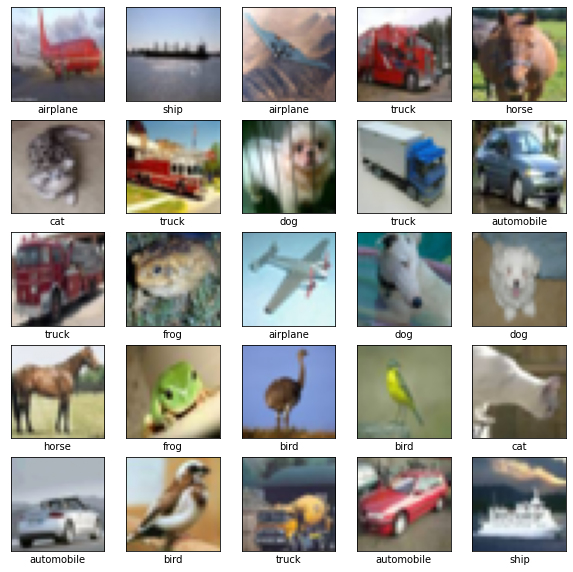

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y[i][0]])
plt.show()

In [6]:
?shutil.rmtree

Signature: shutil.rmtree(path, ignore_errors=False, onerror=None)
Docstring:
Recursively delete a directory tree.

If ignore_errors is set, errors are ignored; otherwise, if onerror
is set, it is called to handle the error with arguments (func,
path, exc_info) where func is platform and implementation dependent;
path is the argument to that function that caused it to fail; and
exc_info is a tuple returned by sys.exc_info().  If ignore_errors
is false and onerror is None, an exception is raised.
File:      /usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib/python3.8/shutil.py
Type:      function


In [17]:
class ImageClass:
    def __init__(self, save_path, architecture):
        self.save_path = save_path
        self.architecture = architecture
        
        self.saving_setup()
        
        self.compile_model()
        
    def saving_setup(self):
        shutil.rmtree(self.save_path, ignore_errors=True)        
        os.makedirs(self.save_path)
        
    def compile_model(self):
        self.model = models.Sequential()
        for key in architecture:
            layer = getattr(layers, self.architecture[key]["layer"])
            args = self.architecture[key]["args"]
            self.model.add(layer(**args))
            
        self.model.compile(optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

    def model_name(self):
        existing_models = os.listdir("./models")
        n = len(existing_models)
        
    def fit(self, X, y, X_val, y_val, epochs, patience):
        self.epochs = epochs
        self.patience = patience
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(self.save_path, monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
        
        self.history = self.model.fit(X, y, 
                                 validation_data=(X_val, y_val),
                                 epochs=self.epochs, 
                                 callbacks=[es, mc])
    
    def validate(self):
        self.train_loss = None
        self.train_acc = None
        
        self.test_loss = None
        self.test_acc = None
        
        self.val_loss = None
        self.val_acc = None
    
    def save(self):        
        meta_data = self.__dict__.copy()
        del meta_data['model']
        del meta_data['history']
        
        path = os.path.join(self.save_path, 'meta-data.json')
        with open(path, 'w') as fp:
            json.dump(meta_data, fp)
        

In [5]:
import tensorflow_datasets as tfds
data = tfds.load('cifar10')
train_ds, test_ds = data['train'], data['test']

In [7]:
?train_ds

Type:           PrefetchDataset
String form:    <PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>
Length:         50000
File:           ~/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py
Docstring:      A `Dataset` that asynchronously prefetches its input.
Init docstring:
See `Dataset.prefetch()` for details.

Args:
  input_dataset: The input dataset.
  buffer_size: See `Dataset.prefetch()` for details.
  slack_period: (Optional.) An integer. If non-zero, determines the number
    of GetNext calls before injecting slack into the execution. This may
    reduce CPU contention at the start of a step. Note that a tensorflow
    user should not have to set this manually; enable this behavior
    automatically via `tf.data.Options.experimental_slack` instead. Defaults
    to None.


In [12]:
# Two tensors can be combined into one Dataset object.
features = tf.constant([[1, 3], [2, 1], [3, 3]]) # ==> 3x2 tensor
labels = tf.constant(['A', 'B', 'A']) # ==> 3x1 tensor
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

In [14]:
train_ds

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

In [13]:
dataset

<TensorSliceDataset shapes: ((2,), ()), types: (tf.int32, tf.string)>

In [15]:
# Both the features and the labels tensors can be converted
# to a Dataset object separately and combined after.
features_dataset = tf.data.Dataset.from_tensor_slices(features)
labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
dataset = Dataset.zip((features_dataset, labels_dataset))
# A batched feature and label set can be converted to a Dataset
# in similar fashion.

In [16]:
batched_features = tf.constant([[[1, 3], [2, 3]],
                                [[2, 1], [1, 2]],
                                [[3, 3], [3, 2]]], shape=(3, 2, 2))
batched_labels = tf.constant([['A', 'A'],
                              ['B', 'B'],
                              ['A', 'B']], shape=(3, 2, 1))
dataset = tf.data.Dataset.from_tensor_slices((batched_features, batched_labels))
for element in dataset.as_numpy_iterator():
    print(element)

(array([[1, 3],
       [2, 3]], dtype=int32), array([[b'A'],
       [b'A']], dtype=object))
(array([[2, 1],
       [1, 2]], dtype=int32), array([[b'B'],
       [b'B']], dtype=object))
(array([[3, 3],
       [3, 2]], dtype=int32), array([[b'A'],
       [b'B']], dtype=object))


In [ ]:
def standardize_record(record):
    return tf.cast(record['image'], tf.float32) / 255., record['label']


train_ds = train_ds.map(standardize_record).cache().batch(64).shuffle(10000)
test_ds = test_ds.map(standardize_record).cache().batch(64)

In [18]:
architecture = {
    0: {"layer": "Conv2D", "args": {"filters": 32, "kernel_size": (3, 3), "activation": "relu", "input_shape": (32, 32, 3)}},
    1: {"layer": "MaxPooling2D", "args": {"pool_size": (2, 2)}},
    2: {"layer": "Conv2D", "args": {"filters": 64, "kernel_size": (3, 3), "activation": "relu"}},
    3: {"layer": "MaxPooling2D", "args": {"pool_size": (2, 2)}},
    4: {"layer": "Conv2D", "args": {"filters": 64, "kernel_size": (3, 3), "activation": "relu"}},
    5: {"layer": "Flatten", "args": {}},
    6: {"layer": "Dense", "args": {"units": 64, "activation": 'relu'}},
    7: {"layer": "Dense", "args": {"units": 10}}
}

model = ImageClass("./models/test/", architecture)

model.fit(X, y, X_val, y_val, 1, 1)
model.save()

110/110 [==============================] - 2s 20ms/step - loss: 2.1250 - accuracy: 0.1966 - val_loss: 1.9053 - val_accuracy: 0.2760


In [23]:
import kerastuner as kt
import tensorflow as tf
import tensorflow_datasets as tfds

def build_model(hp):
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = inputs
    for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
        filters = hp.Int('filters_' + str(i), 32, 256, step=32)
        for _ in range(2):
            x = tf.keras.layers.Convolution2D(
              filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
    x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
    return model


tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2)


tuner.search(tf.data.Dataset.from_tensor_slices((X, y)),
             validation_data=tf.data.Dataset.from_tensor_slices((X_val, y_val)),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json



Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
conv_blocks       |3                 |3                 
filters_0         |192               |32                
filters_1         |32                |224               
filters_2         |32                |96                
pooling_2         |avg               |avg               
hidden_size       |70                |30                
dropout           |0.5               |0.2               
learning_rate     |0.00013589        |0.00041181        
pooling_0         |avg               |avg               
pooling_1         |avg               |avg               
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |3                 |3                 
tuner/round       |0                 |0                 

Epoch 1/2


ValueError: in user code:

    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Users/adammills-campisi/Documents/UW-coursework/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [32, 32, 3]


In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model.fit(X, y, 
                    validation_data=(X_val, y_val),
                    epochs=1000, 
                    callbacks=[es, mc])

saved_model = load_model('best_model.h5')

Epoch 1/2
108/110 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy: 0.9635
Epoch 00001: val_accuracy improved from -inf to 0.40400, saving model to best_model.h5
110/110 [==============================] - 3s 27ms/step - loss: 0.1756 - accuracy: 0.9634 - val_loss: 10.5629 - val_accuracy: 0.4040
Epoch 2/2
110/110 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9809
Epoch 00002: val_accuracy did not improve from 0.40400
110/110 [==============================] - 3s 25ms/step - loss: 0.0662 - accuracy: 0.9809 - val_loss: 10.2331 - val_accuracy: 0.3880


In [9]:
# evaluate the model
train_loss, train_acc = saved_model.evaluate(X, y, verbose=0)
val_loss, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)

In [10]:
pd.DataFrame([('Train', train_loss, train_acc),
 ('Val', val_loss, val_acc),
 ('Test', test_loss, test_acc)], columns=['Data', 'Loss', 'Accuracy'])

,Data,Loss,Accuracy
0,Train,0.000011,0.102286
1,Val,8.639616,0.097000
2,Test,8.882017,0.082000


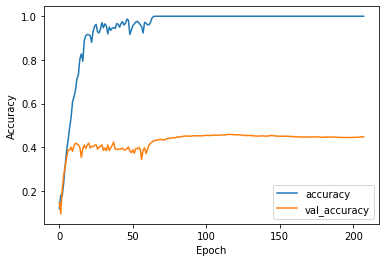

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

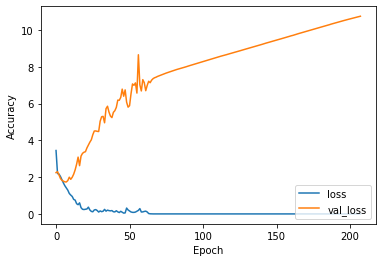

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')